In [ ]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 7.3MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 9.1MB/s 


In [ ]:
!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip

--2021-02-24 09:55:05--  https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cb3g53z4pbtaqvl/erm.zip [following]
--2021-02-24 09:55:06--  https://www.dropbox.com/s/dl/cb3g53z4pbtaqvl/erm.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6c7c88ac59ddea7e73294bbe86.dl.dropboxusercontent.com/cd/0/get/BJi-uJVV1CJzOi4Dh4JXnDjit1JNMyzUzgaArIE0QBjosx-8fiqcXvD1gxXAf4WTObnAwzJVpfvywlb2yiTkSx0vfven44alMNHK7cvowwcyjub_6FlwgXE7UwEf2Xy71_o/file?dl=1# [following]
--2021-02-24 09:55:06--  https://uc6c7c88ac59ddea7e73294bbe86.dl.dropboxusercontent.com/cd/0/get/BJi-uJVV1CJzOi4Dh4JXnDjit1JNMyzUzgaArIE0QBjosx-8fiqcXvD1gxXAf4WTObnAwzJVpfvywlb2yiTkSx0vfven44alMNHK7cvowwcyjub_6FlwgXE7UwEf

In [ ]:
!unzip erm.zip

Archive:  erm.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/no/
  inflating: dataset/test/no/anonymized_1421704.jpg  
  inflating: dataset/test/no/anonymized_336537.jpg  
  inflating: dataset/test/no/anonymized_569526.jpg  
  inflating: dataset/test/no/anonymized_196860.jpg  
  inflating: dataset/test/no/anonymized_920184.jpg  
  inflating: dataset/test/no/anonymized_1348815.jpg  
  inflating: dataset/test/no/anonymized_225304.jpg  
  inflating: dataset/test/no/anonymized_816099.jpg  
  inflating: dataset/test/no/anonymized_260226.jpg  
  inflating: dataset/test/no/anonymized_1619231.jpg  
  inflating: dataset/test/no/anonymized_1314755.jpg  
  inflating: dataset/test/no/anonymized_1182585.jpg  
  inflating: dataset/test/no/anonymized_656024.jpg  
  inflating: dataset/test/no/anonymized_198917.jpg  
  inflating: dataset/test/no/anonymized_246204.jpg  
  inflating: dataset/test/no/anonymized_324557.jpg  
  inflating: dataset/test/no/anonymized_492637.jpg

In [ ]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [ ]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [ ]:
def getDataBlock(presize=512,size=224):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [ ]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [ ]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='vit')
]

In [ ]:
import timm
timm.list_models('*vit*')

['vit_base_patch16_224',
 'vit_base_patch16_384',
 'vit_base_patch32_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50d_224',
 'vit_huge_patch16_224',
 'vit_huge_patch32_384',
 'vit_large_patch16_224',
 'vit_large_patch16_384',
 'vit_large_patch32_384',
 'vit_small_patch16_224',
 'vit_small_resnet26d_224',
 'vit_small_resnet50d_s3_224']

In [ ]:
import timm
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == target).float().mean()
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            # perform a single optimization step (parameter update)
            if device.type == "xla":
                xm.optimizer_step(optimizer)

                if i % 20 == 0:
                    xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

            else:
                optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = (output.argmax(dim=1) == target).float().mean()
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [ ]:
learn = Learner(dls512,ViTBase16(2,True),metrics=accuracy,cbs=callbacks)

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=9.999999747378752e-06)

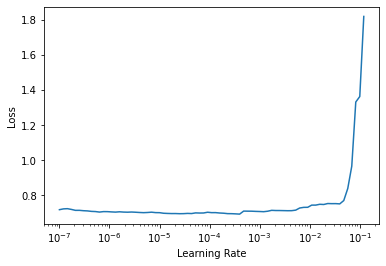

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.691967,0.673953,0.594801,01:44


Better model found at epoch 0 with valid_loss value: 0.6739532351493835.


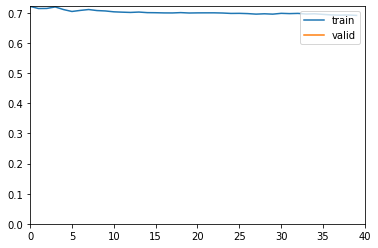

epoch,train_loss,valid_loss,accuracy,time
0,0.663284,0.655334,0.585627,01:45
1,0.656816,0.639958,0.622324,01:45
2,0.642493,0.615595,0.668196,01:45
3,0.621285,0.600325,0.672783,01:45
4,0.598536,0.587331,0.692661,01:45
5,0.579764,0.579888,0.698777,01:45
6,0.565154,0.569768,0.700306,01:45
7,0.550405,0.572752,0.701835,01:45
8,0.540730,0.567965,0.704893,01:45
9,0.535808,0.567998,0.704893,01:45


Better model found at epoch 0 with valid_loss value: 0.6553338766098022.


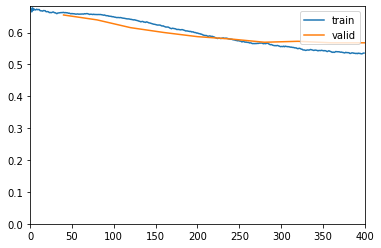

Better model found at epoch 1 with valid_loss value: 0.6399577856063843.
Better model found at epoch 2 with valid_loss value: 0.6155951023101807.
Better model found at epoch 3 with valid_loss value: 0.6003246903419495.
Better model found at epoch 4 with valid_loss value: 0.5873310565948486.
Better model found at epoch 5 with valid_loss value: 0.5798876285552979.
Better model found at epoch 6 with valid_loss value: 0.5697675943374634.
Better model found at epoch 8 with valid_loss value: 0.5679647922515869.


In [ ]:
learn.fine_tune(10,base_lr=1e-5)

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

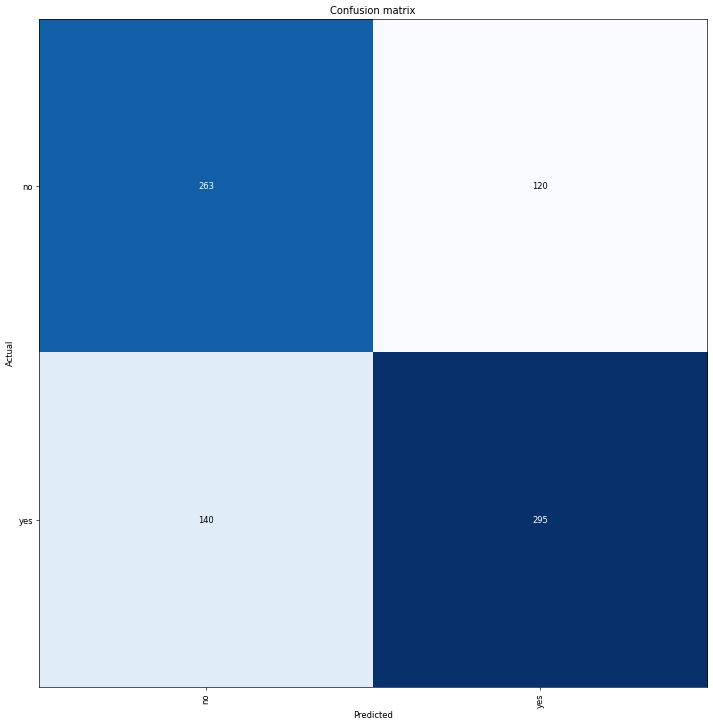

In [ ]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [ ]:
learn.metrics=[accuracy,Precision(),Recall()]

In [ ]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6821516156196594.


(#4) [0.5952262878417969,0.6821516156196594,0.7108433734939759,0.6781609195402298]

In [ ]:
learn.export(fname='resnet50.pkl')